# Test State Extraction and Clustering Metrics

This notebook tests the StateExtractor and clustering metrics that will be used for the RL reward function.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
from scipy.stats import f_oneway, entropy
from sklearn.metrics import silhouette_score, silhouette_samples, mutual_info_score

# Import our environment modules
import sys
sys.path.insert(0, '..')
from rl_sc_cluster_utils.environment.state import StateExtractor
from rl_sc_cluster_utils.environment.clustering_env import ClusteringEnv

2025-12-02 14:32:22.199 | INFO     | rl_sc_cluster_utils.config:<module>:11 - PROJ_ROOT path is: /Users/michaelhaidar/Documents/Vanderbilt/Brain_Research/rl_sc_cluster


## 1. Load Data

In [4]:
# Load the interneuron data
data_path = '/Users/michaelhaidar/Documents/Vanderbilt/Brain_Research/rl_sc_cluster/data/processed/human_interneurons.h5ad'
adata = sc.read_h5ad(data_path)

print(f"Data shape: {adata.shape}")
print(f"Number of cells: {adata.n_obs}")
print(f"Number of genes: {adata.n_vars}")
print(f"\nAvailable obs columns: {list(adata.obs.columns)}")
print(f"\nAvailable obsm keys: {list(adata.obsm.keys())}")
print(f"\nAvailable uns keys: {list(adata.uns.keys())}")

Data shape: (121427, 32165)
Number of cells: 121427
Number of genes: 32165

Available obs columns: ['Class', 'Region', 'sex', 'development_stage', 'Batch_ID', 'Age', '_scvi_batch', '_scvi_labels', 'doublet', 'singlet', 'leiden', 'GAG_CS_biosynthesis', 'GAG_CS_sulfation', 'GAG_HS_biosynthesis', 'GAG_HS_sulfation', 'GAG_Sulfate_activation', 'GAG_PNN_core', 'GAG_overall']

Available obsm keys: ['X_scvi_large', 'X_umap', 'scVI']

Available uns keys: ['_scvi_manager_uuid', '_scvi_uuid', 'leiden', 'leiden_colors', 'leiden_sizes', 'neighbors', 'paga', 'umap']


/opt/homebrew/Caskroom/miniforge/base/envs/rl_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [5]:
# Check the data structure
adata

AnnData object with n_obs × n_vars = 121427 × 32165
    obs: 'Class', 'Region', 'sex', 'development_stage', 'Batch_ID', 'Age', '_scvi_batch', '_scvi_labels', 'doublet', 'singlet', 'leiden', 'GAG_CS_biosynthesis', 'GAG_CS_sulfation', 'GAG_HS_biosynthesis', 'GAG_HS_sulfation', 'GAG_Sulfate_activation', 'GAG_PNN_core', 'GAG_overall'
    var: 'ensembl_id', 'gene_symbol'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'leiden', 'leiden_colors', 'leiden_sizes', 'neighbors', 'paga', 'umap'
    obsm: 'X_scvi_large', 'X_umap', 'scVI'
    obsp: 'connectivities', 'distances'

## 2. Define GAG Gene Sets

In [26]:
# GAG-sulfation gene sets for PNN biology
# gag_gene_sets = {
#     'CS_biosynthesis': ['CSGALNACT1', 'CSGALNACT2', 'CHSY1', 'CHSY3', 'CHPF', 'CHPF2'],
#     'CS_sulfation': ['CHST11', 'CHST12', 'CHST13', 'CHST14', 'CHST15'],
#     'HS_biosynthesis': ['EXT1', 'EXT2', 'EXTL1', 'EXTL2', 'EXTL3'],
#     'HS_sulfation': ['NDST1', 'NDST2', 'HS2ST1', 'HS6ST1', 'HS6ST2', 'HS6ST3', 'HS3ST1', 'HS3ST2'],
#     'Sulfate_activation': ['PAPSS1', 'PAPSS2', 'SLC35B2', 'SLC35B3'],
#     'PNN_core': ['ACAN', 'BCAN', 'NCAN', 'VCAN', 'HAPLN1', 'HAPLN2', 'HAPLN4', 'TNC', 'TNR']
# }

gag_gene_sets = {
    "CS_biosynthesis": [
        "CSGALNACT1","CSGALNACT2",
        "CHSY1","CHSY2","CHSY3",
        "CHPF","CHPF2"
    ],
    "CS_sulfation": [
        "CHST11","CHST12","CHST13","CHST14",
        "CHST3","CHST7","CHST15"
    ],
    "HS_biosynthesis": [
        "EXT1","EXT2","EXTL1","EXTL2","EXTL3","EXTL4"
    ],
    "HS_sulfation": [
        "NDST1","NDST2","NDST3","NDST4",
        "HS2ST1",
        "HS6ST1","HS6ST2","HS6ST3",
        "HS3ST1","HS3ST2","HS3ST3A1","HS3ST3B1","HS3ST4","HS3ST5","HS3ST6"
    ],
    "Sulfate_activation": [
        "PAPSS1","PAPSS2","SLC35B2","SLC35B3","SLC26A2"
    ],
    "PNN_core": [
        "ACAN","BCAN","NCAN","VCAN",
        "HAPLN1","HAPLN2","HAPLN3","HAPLN4",
        "HAS1","HAS2","HAS3",
        "TNC","TNR","SPOCK1","CRTAC1"
    ]
}


print(f"Number of gene sets: {len(gag_gene_sets)}")
for name, genes in gag_gene_sets.items():
    print(f"  {name}: {len(genes)} genes")

Number of gene sets: 6
  CS_biosynthesis: 7 genes
  CS_sulfation: 7 genes
  HS_biosynthesis: 6 genes
  HS_sulfation: 15 genes
  Sulfate_activation: 5 genes
  PNN_core: 15 genes


In [7]:
try:
    from pybiomart import Dataset
    print("Using pybiomart for conversion...")
    dataset = Dataset(name='hsapiens_gene_ensembl', host='http://www.ensembl.org')
    mapping = dataset.query(attributes=['ensembl_gene_id', 'external_gene_name'])
    mapping_dict = dict(zip(mapping['Gene stable ID'], mapping['Gene name']))
    
    # Save original Ensembl IDs
    ensembl_ids = adata.var_names.tolist()
    
    # Update var_names
    new_var_names = [mapping_dict.get(ens_id, ens_id) for ens_id in ensembl_ids]
    
    # Store both
    adata.var['ensembl_id'] = ensembl_ids
    adata.var['gene_symbol'] = new_var_names
    adata.var_names = new_var_names
    
    print("Conversion complete using pybiomart!")
    print(f"Example mappings:")
    for i in range(min(5, len(ensembl_ids))):
        print(f"  {ensembl_ids[i]} -> {new_var_names[i]}")
except ImportError:
    print("Neither mygene nor pybiomart available.")
    print("Please install one of them: pip install mygene")
    print("Or manually create a mapping file.")


Using pybiomart for conversion...
Conversion complete using pybiomart!
Example mappings:
  TSPAN6 -> TSPAN6
  TNMD -> TNMD
  DPM1 -> DPM1
  SCYL3 -> SCYL3
  FIRRM -> FIRRM


In [27]:
# Check which GAG genes are present in the dataset
print("GAG genes present in dataset:\n")
total_found = 0
total_genes = 0

for set_name, genes in gag_gene_sets.items():
    found = [g for g in genes if g in adata.var_names]
    missing = [g for g in genes if g not in adata.var_names]
    total_found += len(found)
    total_genes += len(genes)
    
    print(f"{set_name}:")
    print(f"  Found ({len(found)}): {found}")
    if missing:
        print(f"  Missing ({len(missing)}): {missing}")
    print()

print(f"Total: {total_found}/{total_genes} genes found")

GAG genes present in dataset:

CS_biosynthesis:
  Found (6): ['CSGALNACT1', 'CSGALNACT2', 'CHSY1', 'CHSY3', 'CHPF', 'CHPF2']
  Missing (1): ['CHSY2']

CS_sulfation:
  Found (7): ['CHST11', 'CHST12', 'CHST13', 'CHST14', 'CHST3', 'CHST7', 'CHST15']

HS_biosynthesis:
  Found (5): ['EXT1', 'EXT2', 'EXTL1', 'EXTL2', 'EXTL3']
  Missing (1): ['EXTL4']

HS_sulfation:
  Found (14): ['NDST1', 'NDST2', 'NDST3', 'NDST4', 'HS2ST1', 'HS6ST1', 'HS6ST2', 'HS6ST3', 'HS3ST1', 'HS3ST2', 'HS3ST3A1', 'HS3ST4', 'HS3ST5', 'HS3ST6']
  Missing (1): ['HS3ST3B1']

Sulfate_activation:
  Found (5): ['PAPSS1', 'PAPSS2', 'SLC35B2', 'SLC35B3', 'SLC26A2']

PNN_core:
  Found (15): ['ACAN', 'BCAN', 'NCAN', 'VCAN', 'HAPLN1', 'HAPLN2', 'HAPLN3', 'HAPLN4', 'HAS1', 'HAS2', 'HAS3', 'TNC', 'TNR', 'SPOCK1', 'CRTAC1']

Total: 52/55 genes found


## 3. Prepare Data for Clustering

In [9]:
# Check if we have scVI embeddings
if 'X_scvi' in adata.obsm:
    print(f"X_scvi shape: {adata.obsm['X_scvi'].shape}")
    use_rep = 'X_scvi'
elif 'X_scvi_large' in adata.obsm:
    print(f"X_scvi_large shape: {adata.obsm['X_scvi_large'].shape}")
    # Rename for consistency
    adata.obsm['X_scvi'] = adata.obsm['X_scvi_large']
    use_rep = 'X_scvi'
elif 'scVI' in adata.obsm:
    print(f"scVI shape: {adata.obsm['scVI'].shape}")
    adata.obsm['X_scvi'] = adata.obsm['scVI']
    use_rep = 'X_scvi'
else:
    print("No scVI embeddings found. Computing PCA...")
    sc.pp.pca(adata, n_comps=30)
    use_rep = 'X_pca'

print(f"\nUsing representation: {use_rep}")

X_scvi_large shape: (121427, 40)

Using representation: X_scvi


In [10]:
# Compute neighbors graph if not present
if 'neighbors' not in adata.uns:
    print("Computing neighbors graph...")
    sc.pp.neighbors(adata, use_rep=use_rep, n_neighbors=15)
else:
    print("Neighbors graph already computed")

# Compute UMAP for visualization if not present
if 'X_umap' not in adata.obsm:
    print("Computing UMAP...")
    sc.tl.umap(adata)
else:
    print("UMAP already computed")

Neighbors graph already computed
UMAP already computed


## 4. Test Leiden Clustering at Different Resolutions

In [11]:
# Test different resolutions
resolutions = [0.3, 0.5, 0.8, 1.0, 1.5, 2.0]
results = []

for res in resolutions:
    sc.tl.leiden(adata, resolution=res, key_added=f'leiden_{res}', flavor='igraph', n_iterations=2, directed=False)
    n_clusters = len(adata.obs[f'leiden_{res}'].unique())
    print(f"Resolution {res}: {n_clusters} clusters")
    results.append({'resolution': res, 'n_clusters': n_clusters})

results_df = pd.DataFrame(results)
results_df

Resolution 0.3: 71 clusters
Resolution 0.5: 79 clusters
Resolution 0.8: 86 clusters
Resolution 1.0: 89 clusters
Resolution 1.5: 102 clusters
Resolution 2.0: 115 clusters


,resolution,n_clusters
0,0.3,71
1,0.5,79
2,0.8,86
3,1.0,89
4,1.5,102
5,2.0,115


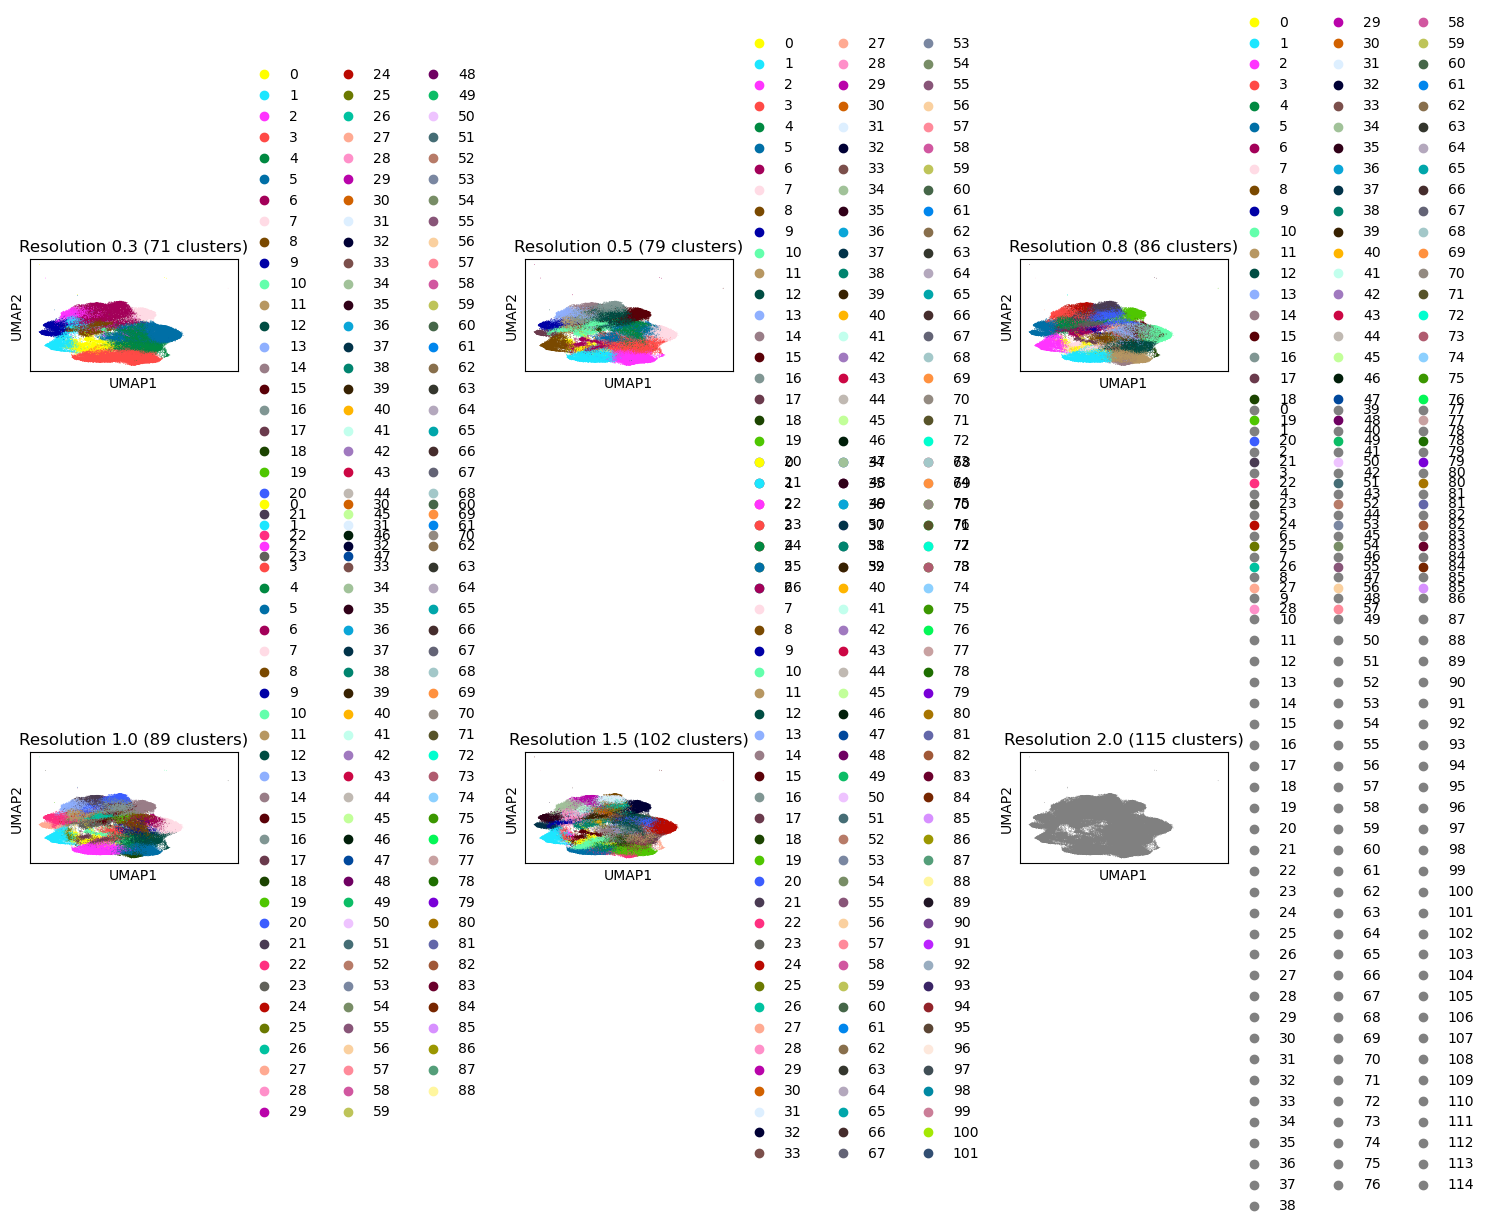

In [12]:
# Visualize clustering at different resolutions
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, res in enumerate(resolutions):
    sc.pl.umap(adata, color=f'leiden_{res}', ax=axes[i], show=False, 
               title=f'Resolution {res} ({len(adata.obs[f"leiden_{res}"].unique())} clusters)')

plt.tight_layout()
plt.show()

## 5. Test Clustering Quality Metrics

In [13]:
# Get embeddings for metric computation
embeddings = adata.obsm[use_rep]

def compute_clustering_metrics(adata, cluster_key, embeddings):
    """Compute all clustering quality metrics."""
    labels = adata.obs[cluster_key]
    n_clusters = len(labels.unique())
    n_cells = adata.n_obs
    
    metrics = {}
    
    # 1. Silhouette score
    if n_clusters > 1 and n_clusters < n_cells:
        metrics['silhouette'] = silhouette_score(embeddings, labels)
    else:
        metrics['silhouette'] = 0.0
    
    # 2. Modularity
    if n_clusters > 1:
        try:
            metrics['modularity'] = sc.metrics.clustering.modularity(adata, label_key=cluster_key)
        except:
            metrics['modularity'] = 0.0
    else:
        metrics['modularity'] = 0.0
    
    # 3. Cluster balance
    cluster_sizes = labels.value_counts()
    if n_clusters > 1:
        mean_size = cluster_sizes.mean()
        std_size = cluster_sizes.std()
        metrics['balance'] = 1.0 - (std_size / (mean_size + 1e-10))
    else:
        metrics['balance'] = 1.0
    
    # 4. Cluster size entropy
    if n_clusters > 1:
        p = cluster_sizes.values / cluster_sizes.sum()
        metrics['entropy'] = entropy(p)
    else:
        metrics['entropy'] = 0.0
    
    # 5. Number of clusters
    metrics['n_clusters'] = n_clusters
    
    # 6. Singleton count (clusters < 10 cells)
    metrics['n_singletons'] = (cluster_sizes < 10).sum()
    
    return metrics

# Compute metrics for each resolution
all_metrics = []
for res in resolutions:
    metrics = compute_clustering_metrics(adata, f'leiden_{res}', embeddings)
    metrics['resolution'] = res
    all_metrics.append(metrics)

metrics_df = pd.DataFrame(all_metrics)
metrics_df

,silhouette,modularity,balance,entropy,n_clusters,n_singletons,resolution
0,-0.156277,0.0,-2.169044,2.069594,71,60,0.3
1,-0.114489,0.0,-1.276648,2.710812,79,60,0.5
2,-0.104214,0.0,-0.972791,3.029436,86,60,0.8
3,-0.097042,0.0,-0.895864,3.129758,89,61,1.0
4,-0.070709,0.0,-0.573413,3.519725,102,60,1.5
5,-0.058601,0.0,-0.388947,3.814364,115,60,2.0


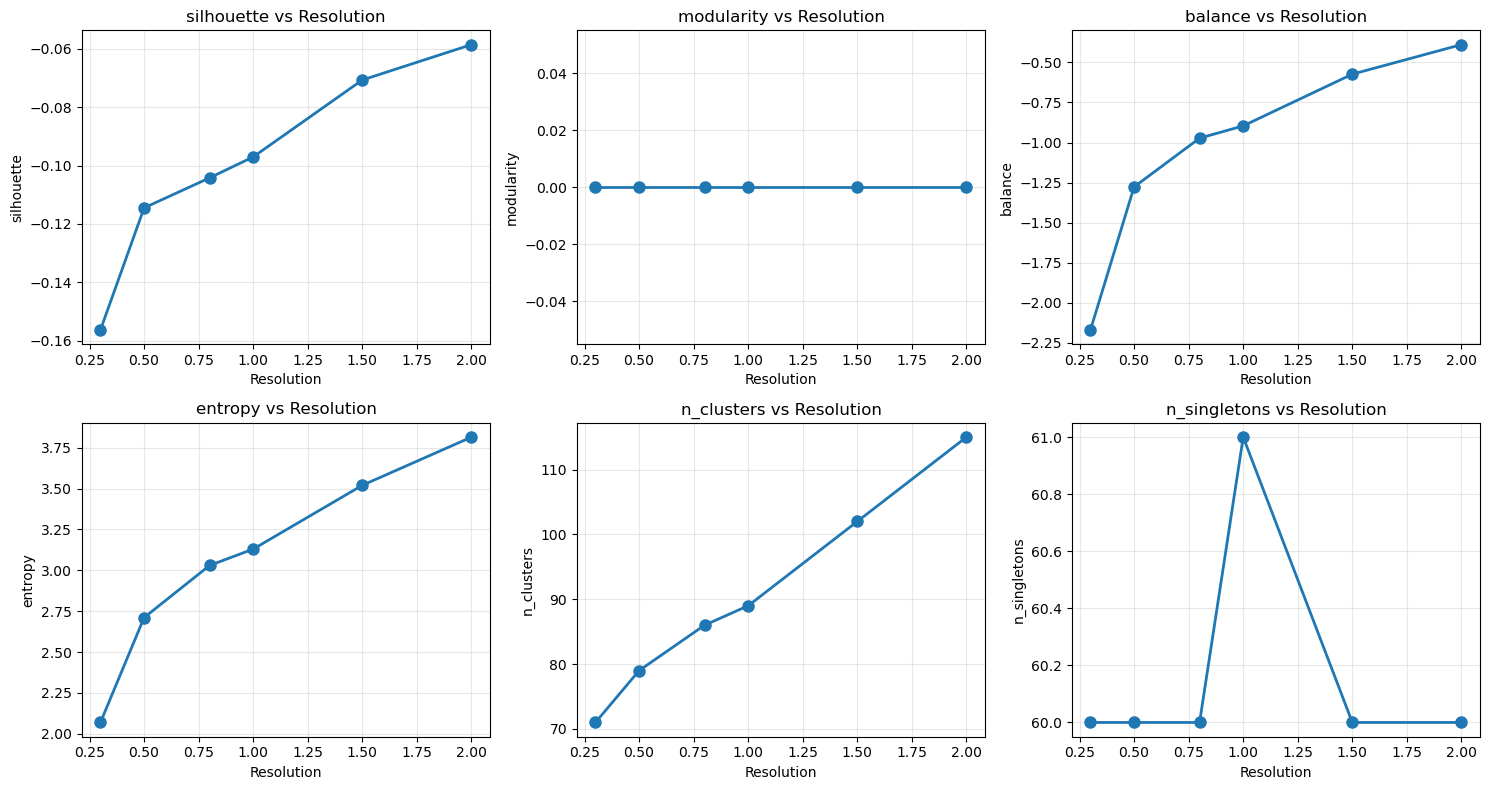

In [14]:
# Plot metrics vs resolution
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

metrics_to_plot = ['silhouette', 'modularity', 'balance', 'entropy', 'n_clusters', 'n_singletons']

for i, metric in enumerate(metrics_to_plot):
    ax = axes.flatten()[i]
    ax.plot(metrics_df['resolution'], metrics_df[metric], 'o-', linewidth=2, markersize=8)
    ax.set_xlabel('Resolution')
    ax.set_ylabel(metric)
    ax.set_title(f'{metric} vs Resolution')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Test GAG Enrichment Metrics

In [15]:
def compute_enrichment_scores(adata, gene_set):
    """Compute simplified enrichment scores (mean expression of gene set)."""
    valid_genes = [g for g in gene_set if g in adata.var_names]
    if len(valid_genes) == 0:
        return None
    
    # Get expression matrix
    if isinstance(adata.X, np.ndarray):
        expr = adata.X
    else:
        expr = adata.X.toarray()
    
    # Get gene indices
    gene_indices = [adata.var_names.get_loc(g) for g in valid_genes]
    
    # Mean expression per cell
    scores = expr[:, gene_indices].mean(axis=1)
    if len(scores.shape) > 1:
        scores = scores.flatten()
    
    return scores

def compute_gag_metrics(adata, cluster_key, gene_sets):
    """Compute GAG enrichment metrics for all gene sets."""
    labels = adata.obs[cluster_key]
    n_clusters = len(labels.unique())
    
    results = {}
    
    for set_name, genes in gene_sets.items():
        scores = compute_enrichment_scores(adata, genes)
        if scores is None:
            results[f'{set_name}_mean'] = 0.0
            results[f'{set_name}_max'] = 0.0
            results[f'{set_name}_F'] = 0.0
            results[f'{set_name}_MI'] = 0.0
            continue
        
        # Compute per-cluster means
        cluster_means = []
        for cluster in labels.unique():
            mask = labels == cluster
            cluster_means.append(scores[mask].mean())
        
        results[f'{set_name}_mean'] = np.mean(cluster_means)
        results[f'{set_name}_max'] = np.max(cluster_means)
        
        # ANOVA F-statistic
        if n_clusters > 1:
            groups = [scores[labels == c] for c in labels.unique()]
            try:
                f_stat, p_val = f_oneway(*groups)
                results[f'{set_name}_F'] = f_stat if not np.isnan(f_stat) else 0.0
                results[f'{set_name}_p'] = p_val if not np.isnan(p_val) else 1.0
            except:
                results[f'{set_name}_F'] = 0.0
                results[f'{set_name}_p'] = 1.0
        else:
            results[f'{set_name}_F'] = 0.0
            results[f'{set_name}_p'] = 1.0
        
        # Mutual information
        if n_clusters > 1:
            try:
                score_bins = np.digitize(scores, np.linspace(scores.min(), scores.max(), 11))
                mi = mutual_info_score(labels, score_bins)
                results[f'{set_name}_MI'] = mi
            except:
                results[f'{set_name}_MI'] = 0.0
        else:
            results[f'{set_name}_MI'] = 0.0
    
    return results

# Test on resolution 0.5
gag_metrics = compute_gag_metrics(adata, 'leiden_0.5', gag_gene_sets)
print("GAG metrics at resolution 0.5:\n")
for k, v in gag_metrics.items():
    print(f"  {k}: {v:.4f}")

GAG metrics at resolution 0.5:

  CS_biosynthesis_mean: 1.5811
  CS_biosynthesis_max: 5.8333
  CS_biosynthesis_F: 214.3999
  CS_biosynthesis_p: 0.0000
  CS_biosynthesis_MI: 0.0309
  CS_sulfation_mean: 0.4671
  CS_sulfation_max: 3.8000
  CS_sulfation_F: 107.3826
  CS_sulfation_p: 0.0000
  CS_sulfation_MI: 0.0215
  HS_biosynthesis_mean: 2.0743
  HS_biosynthesis_max: 6.2000
  HS_biosynthesis_F: 332.0083
  HS_biosynthesis_p: 0.0000
  HS_biosynthesis_MI: 0.0474
  HS_sulfation_mean: 1.8129
  HS_sulfation_max: 7.8750
  HS_sulfation_F: 749.6840
  HS_sulfation_p: 0.0000
  HS_sulfation_MI: 0.0450
  Sulfate_activation_mean: 0.5965
  Sulfate_activation_max: 2.5000
  Sulfate_activation_F: 133.9645
  Sulfate_activation_p: 0.0000
  Sulfate_activation_MI: 0.0281
  PNN_core_mean: 0.4938
  PNN_core_max: 1.6667
  PNN_core_F: 582.8462
  PNN_core_p: 0.0000
  PNN_core_MI: 0.0848


In [16]:
# Compute GAG metrics for all resolutions
gag_all_res = []
for res in resolutions:
    gag_m = compute_gag_metrics(adata, f'leiden_{res}', gag_gene_sets)
    gag_m['resolution'] = res
    gag_all_res.append(gag_m)

gag_df = pd.DataFrame(gag_all_res)

# Show F-statistics across resolutions
f_cols = [c for c in gag_df.columns if c.endswith('_F')]
print("F-statistics by resolution:\n")
print(gag_df[['resolution'] + f_cols])

F-statistics by resolution:

   resolution  CS_biosynthesis_F  CS_sulfation_F  HS_biosynthesis_F  \
0         0.3         185.680130       95.787750         301.162384   
1         0.5         214.399918      107.382576         332.008331   
2         0.8         234.044312      135.692307         362.810150   
3         1.0         224.507446      103.187782         331.676941   
4         1.5         244.489624      136.408234         355.106110   
5         2.0         231.843674      145.719940         348.678101   

   HS_sulfation_F  Sulfate_activation_F  PNN_core_F  
0      528.217407             87.412880  421.866455  
1      749.683960            133.964539  582.846191  
2      746.327759            140.857727  524.930542  
3      759.446289            131.752136  505.160309  
4      696.790710            173.253738  491.218140  
5      740.026611            175.119049  500.307983  


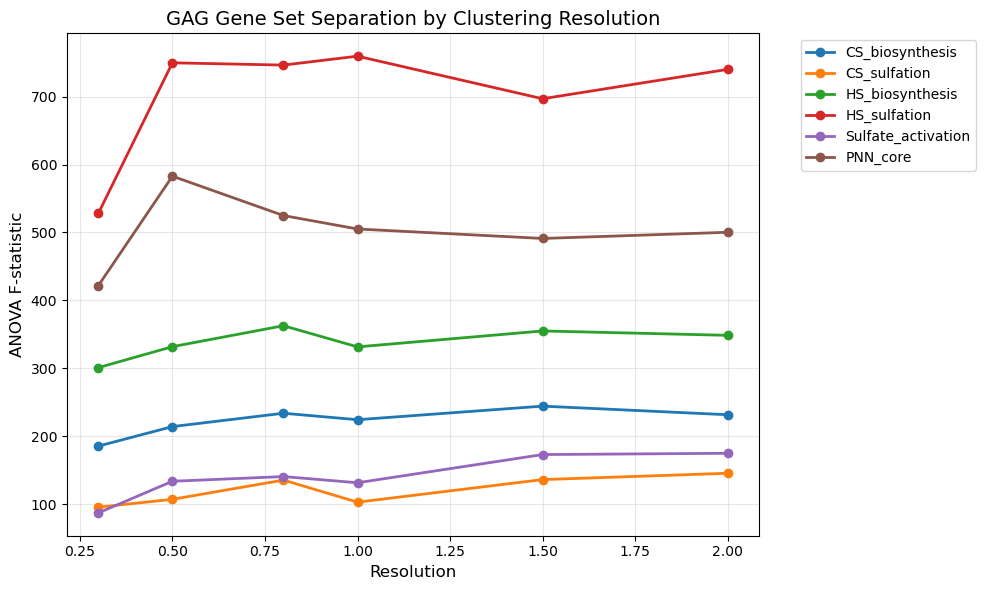

In [17]:
# Plot F-statistics for each gene set across resolutions
fig, ax = plt.subplots(figsize=(10, 6))

for set_name in gag_gene_sets.keys():
    col = f'{set_name}_F'
    if col in gag_df.columns:
        ax.plot(gag_df['resolution'], gag_df[col], 'o-', label=set_name, linewidth=2, markersize=6)

ax.set_xlabel('Resolution', fontsize=12)
ax.set_ylabel('ANOVA F-statistic', fontsize=12)
ax.set_title('GAG Gene Set Separation by Clustering Resolution', fontsize=14)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Compute Composite Reward

In [ ]:
def compute_reward(adata, cluster_key, gene_sets, embeddings, alpha=0.6, beta=0.4, delta=1.0):
    """
    Compute composite reward function.
    
    R = α·Q_cluster + β·Q_GAG - δ·Penalty
    
    Q_cluster = 0.5·silhouette + 0.3·modularity + 0.2·balance
    Q_GAG = mean ANOVA F-statistic across gene sets
    Penalty = degenerate states + singletons

    # F-Stat are normalized to be between 0 and 1 to match scale of other metrics
    # penalty needs to be between 0 and 1
    """
    labels = adata.obs[cluster_key]
    n_clusters = len(labels.unique())
    n_cells = adata.n_obs
    
    # Q_cluster
    cluster_metrics = compute_clustering_metrics(adata, cluster_key, embeddings)
    Q_cluster = (
        0.5 * cluster_metrics['silhouette'] + 
        0.3 * cluster_metrics['modularity'] + 
        0.2 * cluster_metrics['balance']
    )
    
    # Q_GAG (mean F-statistic, normalized)
    gag_metrics = compute_gag_metrics(adata, cluster_key, gene_sets)
    f_stats = [v for k, v in gag_metrics.items() if k.endswith('_F')]
    # Normalize F-stats (they can be large) - use log transform
    f_stats_normalized = [np.log1p(f) / 10.0 for f in f_stats]  # Scale to ~0-1 range
    Q_GAG = np.mean(f_stats_normalized)
    
    # Penalty
    penalty = 0.0
    if n_clusters == 1:
        penalty += 1.0  # Too few clusters
    if n_clusters > 0.3 * n_cells:
        penalty += 1.0  # Too many clusters
    penalty += cluster_metrics['n_singletons'] * 0.1  # Small penalty per singleton
    
    # Composite reward
    reward = alpha * Q_cluster + beta * Q_GAG - delta * penalty
    
    return {
        'reward': reward,
        'Q_cluster': Q_cluster,
        'Q_GAG': Q_GAG,
        'penalty': penalty,
        'silhouette': cluster_metrics['silhouette'],
        'modularity': cluster_metrics['modularity'],
        'balance': cluster_metrics['balance'],
        'n_clusters': n_clusters,
        'n_singletons': cluster_metrics['n_singletons'],
        'mean_F_stat': np.mean(f_stats)
    }

# Compute rewards for all resolutions
rewards = []
for res in resolutions:
    r = compute_reward(adata, f'leiden_{res}', gag_gene_sets, embeddings)
    r['resolution'] = res
    rewards.append(r)

rewards_df = pd.DataFrame(rewards)
print("Reward components by resolution:\n")
print(rewards_df[['resolution', 'reward', 'Q_cluster', 'Q_GAG', 'penalty', 'n_clusters']].to_string(index=False))

Reward components by resolution:

 resolution    reward  Q_cluster    Q_GAG  penalty  n_clusters
        0.3 -6.091746  -0.511947 0.538556      6.0          71
        0.5 -5.962465  -0.312574 0.562699      6.0          79
        0.8 -5.920595  -0.246665 0.568511      6.0          86
        1.0 -6.012476  -0.227694 0.560349      6.1          89
        1.5 -5.861964  -0.150037 0.570147      6.0         102
        2.0 -5.835638  -0.107090 0.571539      6.0         115


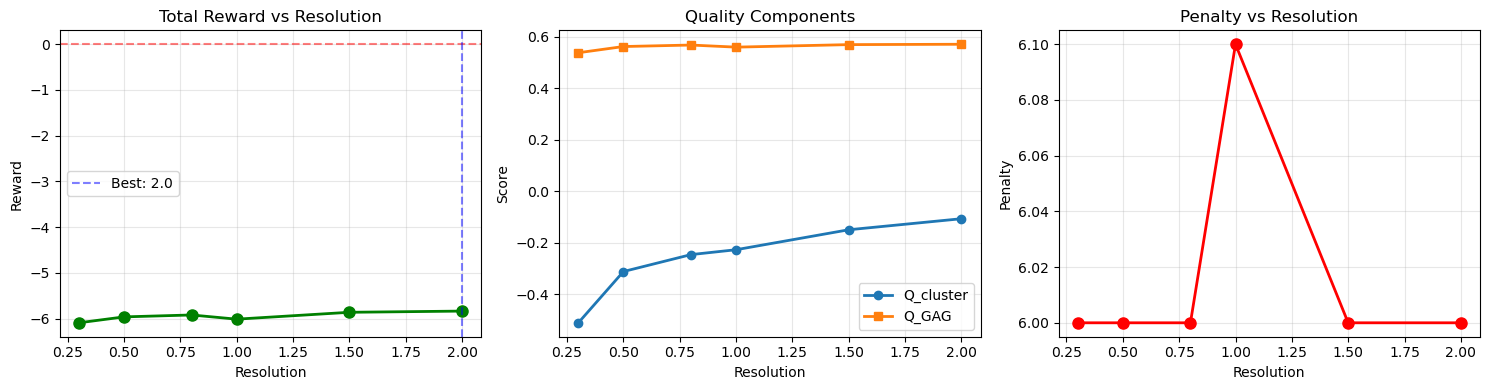


Best resolution: 2.0 with reward: -5.8356


In [19]:
# Plot reward components
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Total reward
axes[0].plot(rewards_df['resolution'], rewards_df['reward'], 'o-', linewidth=2, markersize=8, color='green')
axes[0].set_xlabel('Resolution')
axes[0].set_ylabel('Reward')
axes[0].set_title('Total Reward vs Resolution')
axes[0].grid(True, alpha=0.3)
axes[0].axhline(y=0, color='red', linestyle='--', alpha=0.5)

# Best resolution
best_idx = rewards_df['reward'].idxmax()
best_res = rewards_df.loc[best_idx, 'resolution']
axes[0].axvline(x=best_res, color='blue', linestyle='--', alpha=0.5, label=f'Best: {best_res}')
axes[0].legend()

# Q_cluster vs Q_GAG
axes[1].plot(rewards_df['resolution'], rewards_df['Q_cluster'], 'o-', label='Q_cluster', linewidth=2)
axes[1].plot(rewards_df['resolution'], rewards_df['Q_GAG'], 's-', label='Q_GAG', linewidth=2)
axes[1].set_xlabel('Resolution')
axes[1].set_ylabel('Score')
axes[1].set_title('Quality Components')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Penalty
axes[2].plot(rewards_df['resolution'], rewards_df['penalty'], 'o-', linewidth=2, markersize=8, color='red')
axes[2].set_xlabel('Resolution')
axes[2].set_ylabel('Penalty')
axes[2].set_title('Penalty vs Resolution')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nBest resolution: {best_res} with reward: {rewards_df.loc[best_idx, 'reward']:.4f}")

## 8. Test StateExtractor Class

In [20]:
# Test our StateExtractor
# First, set up clustering
sc.tl.leiden(adata, resolution=0.5, key_added='clusters', flavor='igraph', n_iterations=2, directed=False)

# Create state extractor
state_extractor = StateExtractor(adata, gag_gene_sets, normalize=False)

# Extract state
state = state_extractor.extract_state(adata, step=0, max_steps=15)

print(f"State vector shape: {state.shape}")
print(f"\nState vector breakdown:")
print(f"  Global metrics (0-2):    {state[0:3]}")
print(f"  Quality metrics (3-5):   {state[3:6]}")
print(f"  GAG enrichment (6-33):   {state[6:34].shape} values")
print(f"  Progress (34):           {state[34]}")

State vector shape: (35,)

State vector breakdown:
  Global metrics (0-2):    [6.50596655e-04 1.26582278e-02 2.71081187e+00]
  Quality metrics (3-5):   [-0.11448878  0.         -1.27664779]
  GAG enrichment (6-33):   (28,) values
  Progress (34):           0.0


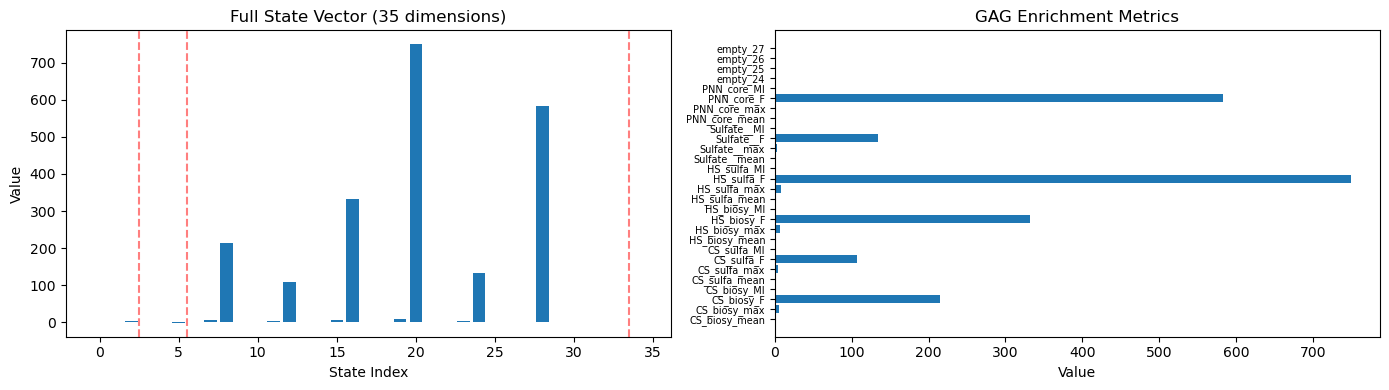

In [21]:
# Visualize state vector
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Full state vector
axes[0].bar(range(35), state)
axes[0].set_xlabel('State Index')
axes[0].set_ylabel('Value')
axes[0].set_title('Full State Vector (35 dimensions)')
axes[0].axvline(x=2.5, color='red', linestyle='--', alpha=0.5)
axes[0].axvline(x=5.5, color='red', linestyle='--', alpha=0.5)
axes[0].axvline(x=33.5, color='red', linestyle='--', alpha=0.5)

# GAG enrichment detail
gag_state = state[6:34]
labels = []
for i, name in enumerate(list(gag_gene_sets.keys())[:7]):
    labels.extend([f'{name[:8]}_mean', f'{name[:8]}_max', f'{name[:8]}_F', f'{name[:8]}_MI'])

# Pad labels if needed
while len(labels) < 28:
    labels.append(f'empty_{len(labels)}')

axes[1].barh(range(len(gag_state)), gag_state)
axes[1].set_yticks(range(len(gag_state)))
axes[1].set_yticklabels(labels[:len(gag_state)], fontsize=7)
axes[1].set_xlabel('Value')
axes[1].set_title('GAG Enrichment Metrics')

plt.tight_layout()
plt.show()

## 9. Test ClusteringEnv

In [22]:
# Create environment
env = ClusteringEnv(adata, gene_sets=gag_gene_sets, max_steps=15)

# Reset and get initial state
state, info = env.reset(seed=42)

print(f"Initial state shape: {state.shape}")
print(f"Initial info: {info}")
print(f"\nAction space: {env.action_space}")
print(f"Observation space: {env.observation_space}")

/opt/homebrew/Caskroom/miniforge/base/envs/rl_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Initial state shape: (35,)
Initial info: {'step': 0, 'resolution': 0.5, 'n_clusters': 79}

Action space: Discrete(5)
Observation space: Box(-inf, inf, (35,), float64)


In [23]:
# Test a few steps (actions are currently placeholders)
print("Testing environment steps (actions are placeholders for now):\n")

for action in [0, 1, 2, 3, 4]:  # Try each action
    env.reset(seed=42)
    next_state, reward, terminated, truncated, info = env.step(action)
    print(f"Action {action}: reward={reward:.4f}, terminated={terminated}, info={info}")

Testing environment steps (actions are placeholders for now):

Action 0: reward=0.0000, terminated=False, info={'action': 0, 'step': 1, 'terminated': False, 'truncated': False, 'resolution': 0.5, 'n_clusters': 79}
Action 1: reward=0.0000, terminated=False, info={'action': 1, 'step': 1, 'terminated': False, 'truncated': False, 'resolution': 0.5, 'n_clusters': 79}
Action 2: reward=0.0000, terminated=False, info={'action': 2, 'step': 1, 'terminated': False, 'truncated': False, 'resolution': 0.5, 'n_clusters': 79}
Action 3: reward=0.0000, terminated=False, info={'action': 3, 'step': 1, 'terminated': False, 'truncated': False, 'resolution': 0.5, 'n_clusters': 79}
Action 4: reward=0.0000, terminated=True, info={'action': 4, 'step': 1, 'terminated': True, 'truncated': False, 'resolution': 0.5, 'n_clusters': 79}


In [24]:
# Validate environment with gymnasium
from gymnasium.utils.env_checker import check_env

try:
    check_env(env, warn=True)
    print("Environment passed gymnasium check!")
except Exception as e:
    print(f"Environment check failed: {e}")

/opt/homebrew/Caskroom/miniforge/base/envs/rl_env/lib/python3.10/site-packages/gymnasium/utils/env_checker.py:367: UserWarning: WARN: `check_env(warn=...)` parameter is now ignored.
  logger.warn("`check_env(warn=...)` parameter is now ignored.")
/opt/homebrew/Caskroom/miniforge/base/envs/rl_env/lib/python3.10/site-packages/gymnasium/utils/env_checker.py:311: UserWarning: WARN: A Box observation space minimum value is -infinity. This is probably too low.
  logger.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/rl_env/lib/python3.10/site-packages/gymnasium/utils/env_checker.py:315: UserWarning: WARN: A Box observation space maximum value is infinity. This is probably too high.
  logger.warn(


Environment passed gymnasium check!


/opt/homebrew/Caskroom/miniforge/base/envs/rl_env/lib/python3.10/site-packages/gymnasium/utils/env_checker.py:434: UserWarning: WARN: Not able to test alternative render modes due to the environment not having a spec. Try instantiating the environment through `gymnasium.make`
  logger.warn(


## 10. Summary and Next Steps

In [25]:
print("=" * 60)
print("SUMMARY")
print("=" * 60)
print(f"\nDataset: {adata.n_obs} cells × {adata.n_vars} genes")
print(f"Embedding: {use_rep} ({adata.obsm[use_rep].shape[1]} dimensions)")
print(f"GAG gene sets: {len(gag_gene_sets)} sets")
print(f"\nBest resolution by reward: {best_res}")
print(f"  - Reward: {rewards_df.loc[best_idx, 'reward']:.4f}")
print(f"  - Q_cluster: {rewards_df.loc[best_idx, 'Q_cluster']:.4f}")
print(f"  - Q_GAG: {rewards_df.loc[best_idx, 'Q_GAG']:.4f}")
print(f"  - N clusters: {rewards_df.loc[best_idx, 'n_clusters']}")
print(f"\nState vector: 35 dimensions")
print(f"  - Global: 3, Quality: 3, GAG: 28, Progress: 1")
print(f"\nEnvironment: ClusteringEnv passes gymnasium check")
print(f"\n" + "=" * 60)
print("NEXT STEPS (Stage 3):")
print("=" * 60)
print("1. Implement split_cluster() action")
print("2. Implement merge_clusters() action")
print("3. Implement recluster() actions")
print("4. Implement RewardCalculator class")
print("5. Connect reward to environment step()")

SUMMARY

Dataset: 121427 cells × 32165 genes
Embedding: X_scvi (40 dimensions)
GAG gene sets: 6 sets

Best resolution by reward: 2.0
  - Reward: -5.8356
  - Q_cluster: -0.1071
  - Q_GAG: 0.5715
  - N clusters: 115

State vector: 35 dimensions
  - Global: 3, Quality: 3, GAG: 28, Progress: 1

Environment: ClusteringEnv passes gymnasium check

NEXT STEPS (Stage 3):
1. Implement split_cluster() action
2. Implement merge_clusters() action
3. Implement recluster() actions
4. Implement RewardCalculator class
5. Connect reward to environment step()
